# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

base_path = "/Users/yijuilee/project_robyn/robynpy_interfaces/Robyn/R/data"
python_path = "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src"
sys.path.append(base_path)
sys.path.append(python_path)

In [2]:
import os
import numpy as np
import pandas as pd
import pyreadr
from typing import Dict, Any
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.data.entities.calibration_input import CalibrationInput
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.ridge_model_builder import RidgeModelBuilder
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeaturizedMMMData, FeatureEngineering
from robyn.calibration.media_effect_calibration import MediaEffectCalibrator

/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
def load_data() -> Dict[str, pd.DataFrame]:
    if not base_path:
        raise EnvironmentError("Please set the ROBYN_BASE_PATH environment variable")

    simulated_weekly_path = os.path.join(base_path, "dt_simulated_weekly.RData")
    prophet_holidays_path = os.path.join(base_path, "dt_prophet_holidays.RData")

    result = pyreadr.read_r(simulated_weekly_path)
    dt_simulated_weekly = result["dt_simulated_weekly"]
    result_holidays = pyreadr.read_r(prophet_holidays_path)
    dt_prophet_holidays = result_holidays["dt_prophet_holidays"]

    return {"dt_simulated_weekly": dt_simulated_weekly, "dt_prophet_holidays": dt_prophet_holidays}


data = load_data()
data["dt_simulated_weekly"].head()
data["dt_prophet_holidays"].head()

,ds,holiday,country,year
0,1995-01-01,New Year's Day,AD,1995
1,1995-01-06,Epiphany,AD,1995
2,1995-02-28,Carnival,AD,1995
3,1995-03-14,Constitution Day,AD,1995
4,1995-04-14,Good Friday,AD,1995


## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(data: Dict[str, pd.DataFrame]) -> MMMData:
    dt_simulated_weekly = data["dt_simulated_weekly"]

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(data)
mmm_data.data.head()

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    hyperparameters={
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=0.0,
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=data["dt_prophet_holidays"],
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

## Add Calibration Step

In [7]:
from robyn.data.entities.enums import CalibrationScope, DependentVarType
from robyn.data.entities.calibration_input import CalibrationInput, ChannelCalibrationData
from robyn.calibration.media_effect_calibration import MediaEffectCalibrator
import pandas as pd

# Create sample calibration data with explicit tuples
channel_calibration_data = {
    ("facebook_S"): ChannelCalibrationData(
        lift_start_date=pd.Timestamp("2018-05-01"),
        lift_end_date=pd.Timestamp("2018-06-10"),
        lift_abs=400000.0,
        spend=421000.0,
        confidence=0.85,
        metric=DependentVarType.REVENUE,
        calibration_scope=CalibrationScope.IMMEDIATE,
    ),
    ("tv_S"): ChannelCalibrationData(
        lift_start_date=pd.Timestamp("2018-04-03"),
        lift_end_date=pd.Timestamp("2018-06-03"),
        lift_abs=300000.0,
        spend=7100.0,
        confidence=0.8,
        metric=DependentVarType.REVENUE,
        calibration_scope=CalibrationScope.IMMEDIATE,
    ),
    ("facebook_S", "search_S"): ChannelCalibrationData(  # Tuple for combined channels
        lift_start_date=pd.Timestamp("2018-07-01"),
        lift_end_date=pd.Timestamp("2018-07-20"),
        lift_abs=700000.0,
        spend=350000.0,
        confidence=0.99,
        metric=DependentVarType.REVENUE,
        calibration_scope=CalibrationScope.IMMEDIATE,
    ),
    ("newsletter"): ChannelCalibrationData(
        lift_start_date=pd.Timestamp("2017-12-01"),
        lift_end_date=pd.Timestamp("2017-12-31"),
        lift_abs=200.0,
        spend=0.0,
        confidence=0.95,
        metric=DependentVarType.REVENUE,
        calibration_scope=CalibrationScope.IMMEDIATE,
    ),
}

# Create the CalibrationInput object directly since keys are already tuples
calibration_input = CalibrationInput(channel_data=channel_calibration_data)

# Convert to DataFrame
df_data = []
for channels, data in calibration_input.channel_data.items():
    df_data.append(
        {
            "channel": "+".join(channels),
            "lift_start_date": data.lift_start_date.strftime("%Y-%m-%d"),
            "lift_end_date": data.lift_end_date.strftime("%Y-%m-%d"),
            "lift_abs": f"{data.lift_abs:,.0f}",
            "spend": f"{data.spend:,.0f}",
            "confidence": f"{data.confidence:.2f}",
            "metric": data.metric.value,
            "calibration_scope": data.calibration_scope.value,
        }
    )

df_calibration_input = pd.DataFrame(df_data)
display(df_calibration_input)

,channel,lift_start_date,lift_end_date,lift_abs,spend,confidence,metric,calibration_scope
0,facebook_S,2018-05-01,2018-06-10,"400,000","421,000",0.85,revenue,immediate
1,tv_S,2018-04-03,2018-06-03,"300,000","7,100",0.80,revenue,immediate
2,facebook_S+search_S,2018-07-01,2018-07-20,"700,000","350,000",0.99,revenue,immediate
3,newsletter,2017-12-01,2017-12-31,200,0,0.95,revenue,immediate


In [8]:
import logging
from typing import Dict


# Define the coefficient function locally in the notebook
def get_model_coefficients(mmm_data: MMMData) -> Dict[str, float]:
    """Get approximate coefficients for channels based on data."""
    coefficients = {}
    dep_var = mmm_data.mmmdata_spec.dep_var

    for channel in mmm_data.mmmdata_spec.paid_media_spends + mmm_data.mmmdata_spec.organic_vars:
        # Calculate simple correlation coefficient
        corr = mmm_data.data[channel].corr(mmm_data.data[dep_var])
        coefficients[channel] = abs(corr)  # Use absolute correlation as coefficient

    return coefficients


# Configure logging to show debug messages
logging.basicConfig(
    level=logging.DEBUG, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S"
)

# Get model coefficients
model_coefficients = get_model_coefficients(mmm_data)
print("\nEstimated model coefficients:")
for channel, coef in model_coefficients.items():
    print(f"{channel}: {coef:.4f}")

# Initialize calibration engine with coefficients
calibration_engine = MediaEffectCalibrator(
    mmm_data=mmm_data,
    hyperparameters=hyperparameters,
    calibration_input=calibration_input,
    model_coefficients=model_coefficients,  # Add this parameter
)

# Perform calibration
calibration_results = calibration_engine.calibrate()

print("\nCalibration Results:")
# Access channel scores specifically
for channel, score in calibration_results.channel_scores.items():
    if len(channel) == 1:
        print(f"{channel[0]}: MAPE = {score:.2%}")
    else:
        print(f"{' + '.join(channel)}: MAPE = {score:.2%}")

print(f"\nOverall Model Calibrated: {calibration_results.is_model_calibrated()}")

# Print detailed channel information
print("\nDetailed Channel Information:")
for channel_tuple, data in calibration_input.channel_data.items():
    channels = channel_tuple if len(channel_tuple) > 1 else channel_tuple[0]
    print(f"\nChannel: {channels}")
    print(f"Lift Period: {data.lift_start_date} to {data.lift_end_date}")
    print(f"Expected Lift: {data.lift_abs:,.2f}")
    print(f"Spend: {data.spend:,.2f}")
    print(f"Confidence: {data.confidence:.2%}")

    # Get actual values from data for this period
    date_col = mmm_data.mmmdata_spec.date_var
    mask = (mmm_data.data[date_col] >= data.lift_start_date) & (mmm_data.data[date_col] <= data.lift_end_date)

    if isinstance(channels, tuple):
        actual_values = sum(mmm_data.data.loc[mask, ch].sum() for ch in channels)
    else:
        actual_values = mmm_data.data.loc[mask, channels].sum()

    print(f"Actual Values Sum: {actual_values:,.2f}")

2024-10-24 20:35:58 - robyn.calibration.media_effect_calibration - INFO - Initializing MediaEffectCalibrator
2024-10-24 20:35:58 - robyn.calibration.media_transformation - INFO - Initializing MediaTransformation
2024-10-24 20:35:58 - robyn.calibration.media_effect_calibration - INFO - Starting calibration process
2024-10-24 20:35:58 - robyn.calibration.media_effect_calibration - INFO - Calibration complete. Mean MAPE: 0.9883



Estimated model coefficients:
tv_S: 0.4199
ooh_S: 0.0953
print_S: 0.2304
facebook_S: 0.3176
search_S: 0.4428
newsletter: 0.4061

Calibration Results:
facebook_S: MAPE = 100.00%
tv_S: MAPE = 100.00%
facebook_S + search_S: MAPE = 100.00%
newsletter: MAPE = 95.33%

Overall Model Calibrated: False

Detailed Channel Information:

Channel: facebook_S
Lift Period: 2018-05-01 00:00:00 to 2018-06-10 00:00:00
Expected Lift: 400,000.00
Spend: 421,000.00
Confidence: 85.00%
Actual Values Sum: 14,049.49

Channel: tv_S
Lift Period: 2018-04-03 00:00:00 to 2018-06-03 00:00:00
Expected Lift: 300,000.00
Spend: 7,100.00
Confidence: 80.00%
Actual Values Sum: 947.11

Channel: ('facebook_S', 'search_S')
Lift Period: 2018-07-01 00:00:00 to 2018-07-20 00:00:00
Expected Lift: 700,000.00
Spend: 350,000.00
Confidence: 99.00%
Actual Values Sum: 22,346.47

Channel: newsletter
Lift Period: 2017-12-01 00:00:00 to 2017-12-31 00:00:00
Expected Lift: 200.00
Spend: 0.00
Confidence: 95.00%
Actual Values Sum: 154,694.00


In [9]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

20:35:59 - cmdstanpy - INFO - Chain [1] start processing
2024-10-24 20:35:59 - cmdstanpy - INFO - Chain [1] start processing
20:35:59 - cmdstanpy - INFO - Chain [1] done processing
2024-10-24 20:35:59 - cmdstanpy - INFO - Chain [1] done processing
2024-10-24 20:35:59 - robyn.modeling.feature_engineering - INFO - Prophet decomposition complete.
2024-10-24 20:35:59 - robyn.modeling.feature_engineering - INFO - Processing tv_S
2024-10-24 20:36:00 - robyn.modeling.feature_engineering - INFO - Processing ooh_S
2024-10-24 20:36:00 - robyn.modeling.feature_engineering - INFO - Processing print_S
2024-10-24 20:36:02 - robyn.modeling.feature_engineering - INFO - Processing facebook_S
2024-10-24 20:36:02 - robyn.modeling.feature_engineering - INFO - Processing search_S
2024-10-24 20:36:02 - robyn.modeling.feature_engineering - INFO - Feature engineering complete.


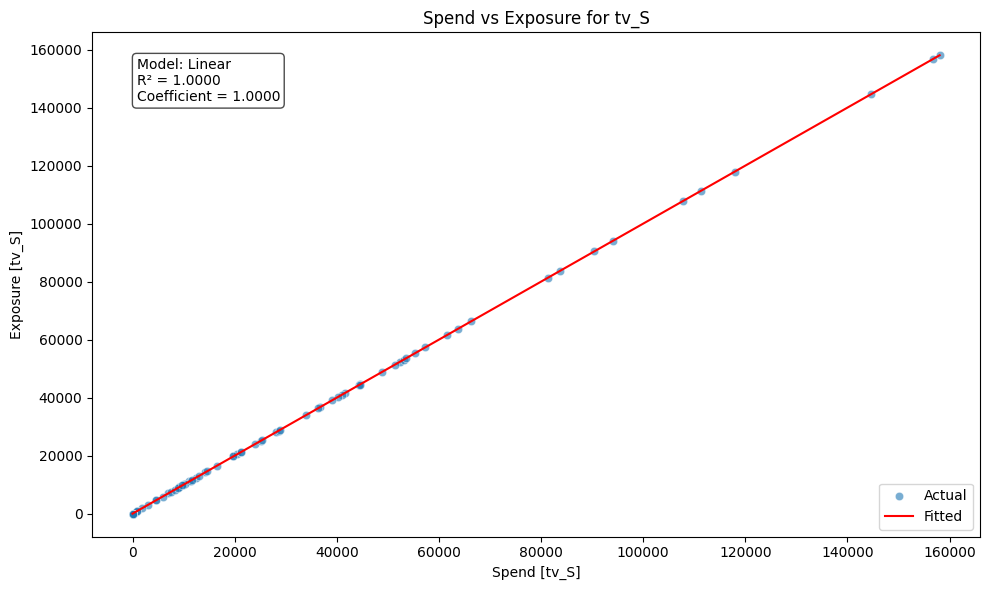

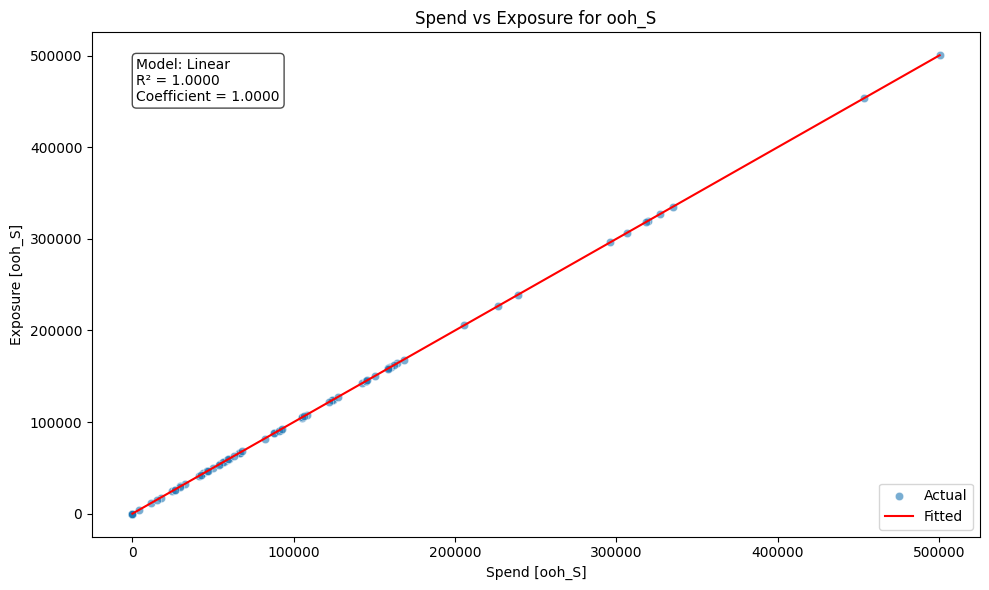

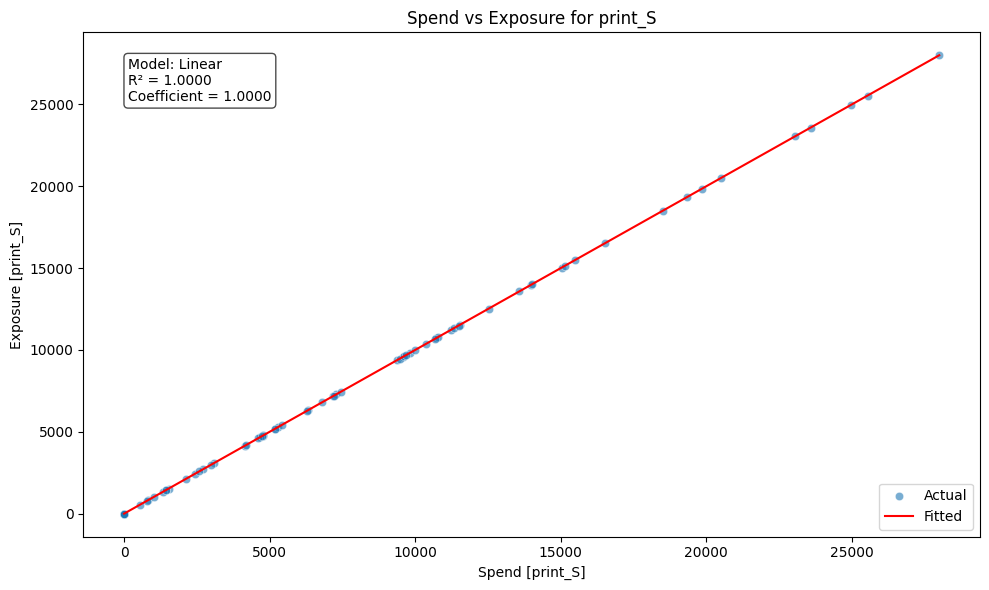

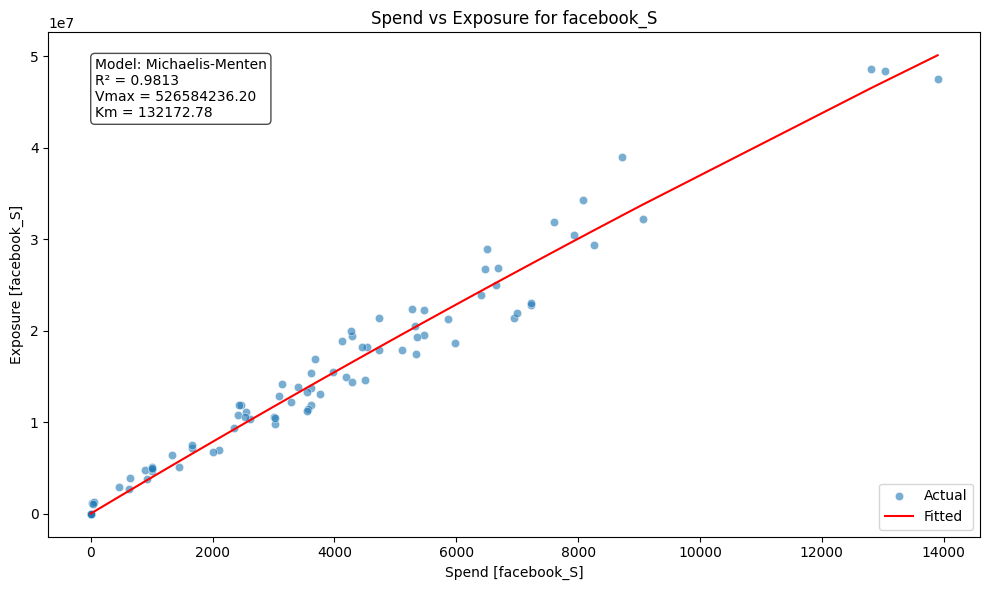

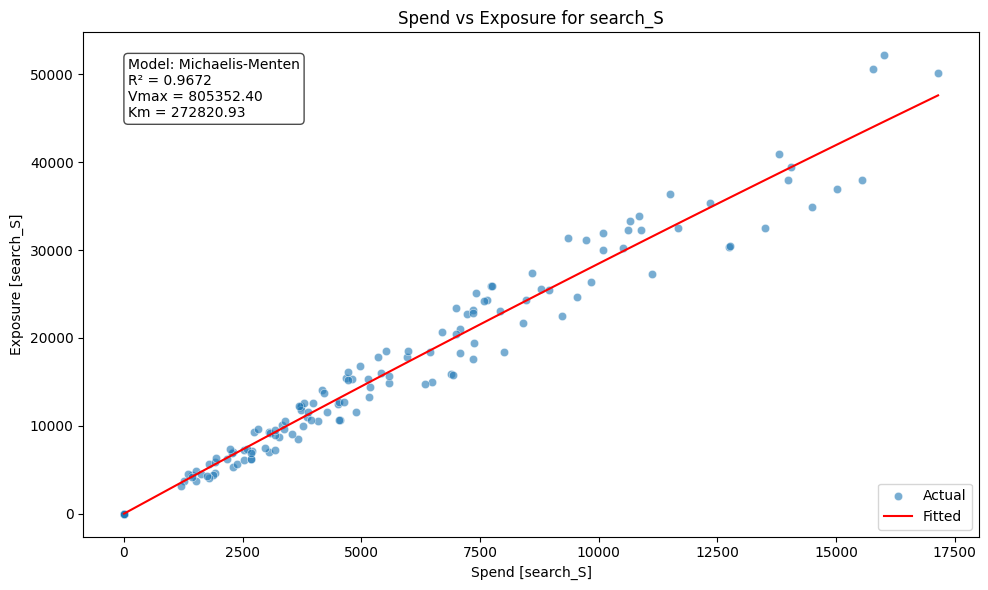

In [10]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters)

# Plot spend-exposure relationship for each channel
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

2024-10-24 20:36:03 - robyn.modeling.ridge_model_builder - INFO - Collecting hyperparameters for optimization... {'prepared_hyperparameters': Hyperparameters(hyperparameters={'facebook_S': ChannelHyperparameters(thetas=[0, 0.3], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'print_S': ChannelHyperparameters(thetas=[0.1, 0.4], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'tv_S': ChannelHyperparameters(thetas=[0.3, 0.8], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'search_S': ChannelHyperparameters(thetas=[0, 0.3], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'ooh_S': ChannelHyperparameters(thetas=[0.1, 0.4], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'newsletter': ChannelHyperparameters(thetas=[0.1, 0.4], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None)}, adstock=<AdstockType.GEOMETRIC: 'geometric'>, lambda_=0.0,

>>> Starting 5 trials with 2000 iterations each using TwoPointsDE nevergrad algorithm on x cores...


Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-10-24 20:37:54 - robyn.modeling.ridge_model_builder - INFO -  Finished in 1.86 mins
Running trial 2 of total 5 trials: 100%|███████████████████████████████████
2024-10-24 20:40:21 - robyn.modeling.ridge_model_builder - INFO -  Finished in 2.42 mins
Running trial 3 of total 5 trials: 100%|███████████████████████████████████
2024-10-24 20:43:18 - robyn.modeling.ridge_model_builder - INFO -  Finished in 2.95 mins
Running trial 4 of total 5 trials: 100%|███████████████████████████████████
2024-10-24 20:45:31 - robyn.modeling.ridge_model_builder - INFO -  Finished in 2.20 mins
Running trial 5 of total 5 trials: 100%|███████████████████████████████████
2024-10-24 20:47:32 - robyn.modeling.ridge_model_builder - INFO -  Finished in 2.00 mins
2024-10-24 20:47:32 - robyn.modeling.convergence.convergence - WARNING - 'mape' column not found or all zeros. Assuming model is not calibrated.
2024-10-24 20:47:32 - matplotl

Model training complete.


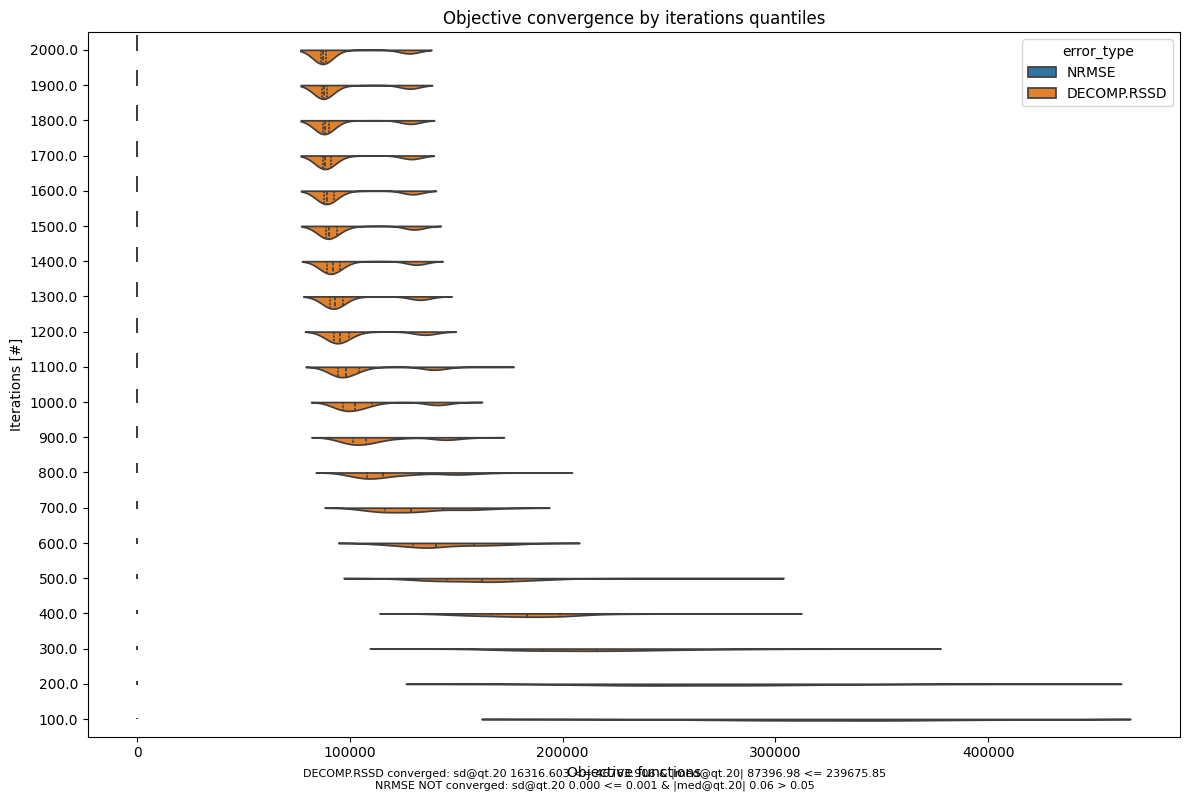

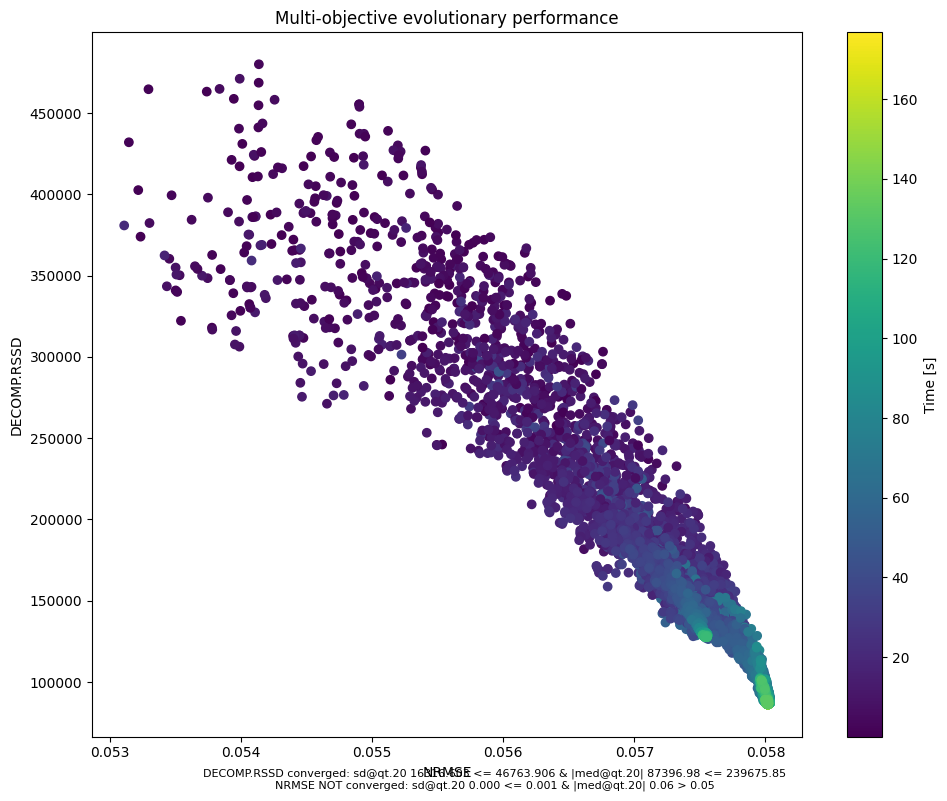

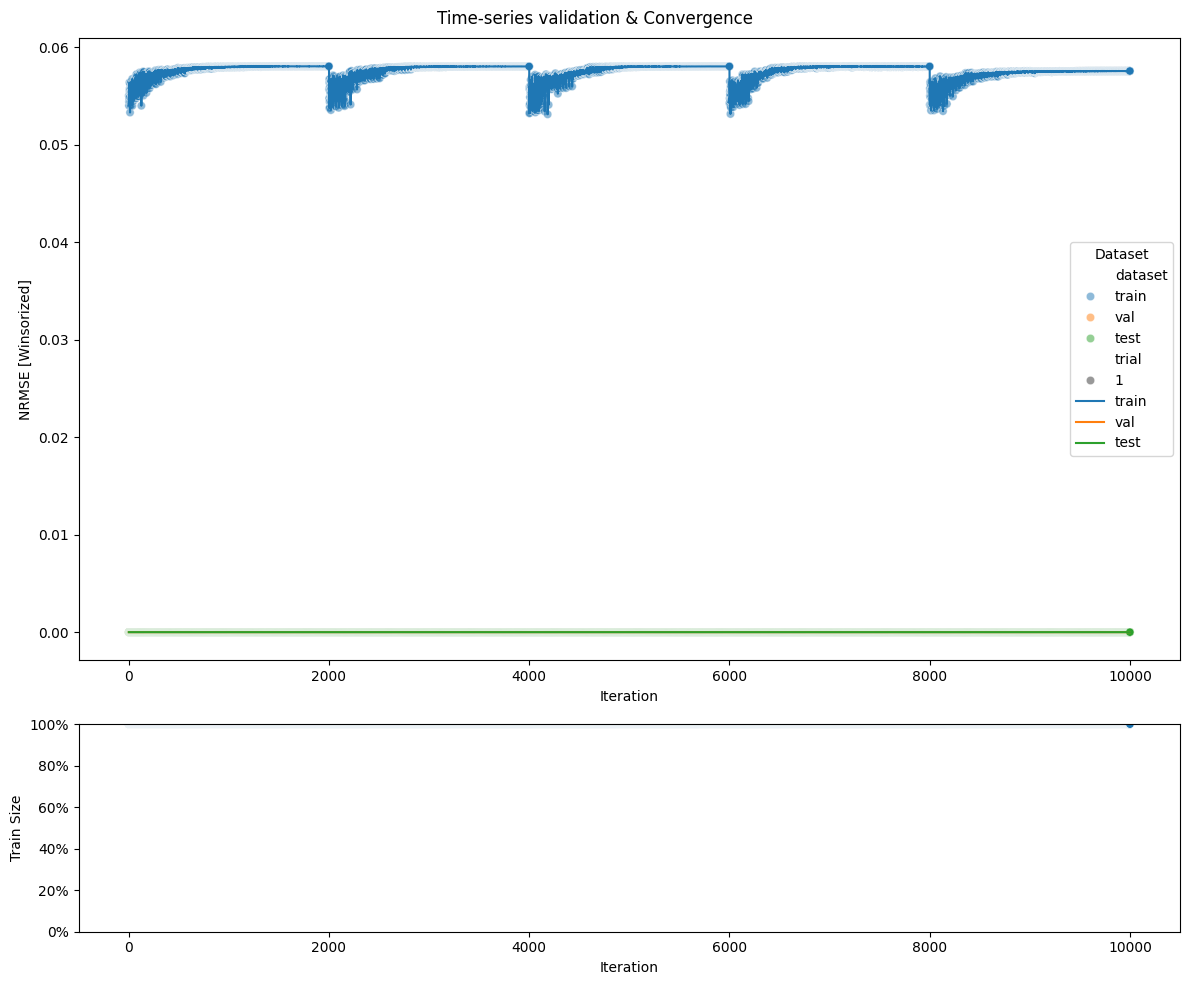

In [11]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(iterations=2000, trials=5)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on x cores..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=False,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

# TODO fix graph outputs

In [12]:
# Assuming model_outputs.trials[0] is already an object from your model
trial = output_models.trials[0]


# Function to check if an object has a 'shape' attribute
def has_shape(obj):
    return hasattr(obj, "shape")


# Get all attribute names of the object and print their shapes if they have a 'shape' attribute
attribute_names = [attr for attr in dir(trial) if not callable(getattr(trial, attr)) and not attr.startswith("__")]
for attribute_name in attribute_names:
    attribute_value = getattr(trial, attribute_name)
    if has_shape(attribute_value):
        print(f"{attribute_name}: Shape = {attribute_value.shape}")
    else:
        print(f"{attribute_name}: No shape attribute, Type = {type(attribute_value).__name__}")

decomp_rssd: Shape = ()
decomp_spend_dist: Shape = (10000, 34)
elapsed: No shape attribute, Type = float
elapsed_accum: No shape attribute, Type = float
iter_ng: No shape attribute, Type = int
iter_par: No shape attribute, Type = int
lambda_: No shape attribute, Type = float
lambda_hp: No shape attribute, Type = float
lambda_max: Shape = ()
lambda_min_ratio: No shape attribute, Type = float
lift_calibration: No shape attribute, Type = NoneType
mape: No shape attribute, Type = float
nrmse: Shape = ()
pos: No shape attribute, Type = bool
result_hyp_param: Shape = (2000, 34)
rsq_test: No shape attribute, Type = float
rsq_train: No shape attribute, Type = float
rsq_val: No shape attribute, Type = float
sol_id: No shape attribute, Type = str
train_size: No shape attribute, Type = float
trial: No shape attribute, Type = int
x_decomp_agg: Shape = (24000, 29)


In [13]:
# Assuming model_outputs.trials[0] is already an object from your model
trial = output_models.trials[0]


# Function to check if an object has a 'shape' attribute
def has_shape(obj):
    return hasattr(obj, "shape")


# Get all attribute names of the object and print their shapes if they have a 'shape' attribute
attribute_names = [attr for attr in dir(trial) if not callable(getattr(trial, attr)) and not attr.startswith("__")]
for attribute_name in attribute_names:
    attribute_value = getattr(trial, attribute_name)
    if has_shape(attribute_value):
        print(f"{attribute_name}: Shape = {attribute_value.shape}")
        # Check if the attribute is a multi-dimensional array with more than one column
        if len(attribute_value.shape) > 1 and attribute_value.shape[1] > 1:
            try:
                # Attempt to print column names if it's a structured array or DataFrame
                columns = (
                    attribute_value.columns if hasattr(attribute_value, "columns") else attribute_value.dtype.names
                )
                print(f"  Columns: {columns}")
            except AttributeError:
                print("  No column names available.")
    else:
        print(f"{attribute_name}: No shape attribute, Type = {type(attribute_value).__name__}")

decomp_rssd: Shape = ()
decomp_spend_dist: Shape = (10000, 34)
  Columns: Index(['rn', 'coef', 'xDecompAgg', 'xDecompPerc', 'xDecompMeanNon0',
       'xDecompMeanNon0Perc', 'xDecompAggRF', 'xDecompPercRF',
       'xDecompMeanNon0RF', 'xDecompMeanNon0PercRF', 'pos', 'mean_spend',
       'total_spend', 'spend_share', 'spend_share_refresh', 'effect_share',
       'effect_share_refresh', 'rsq_train', 'rsq_val', 'rsq_test',
       'nrmse_train', 'nrmse_val', 'nrmse_test', 'nrmse', 'decomp.rssd',
       'mape', 'lambda', 'lambda_hp', 'lambda_max', 'lambda_min_ratio',
       'solID', 'trial', 'iterNG', 'iterPar'],
      dtype='object')
elapsed: No shape attribute, Type = float
elapsed_accum: No shape attribute, Type = float
iter_ng: No shape attribute, Type = int
iter_par: No shape attribute, Type = int
lambda_: No shape attribute, Type = float
lambda_hp: No shape attribute, Type = float
lambda_max: Shape = ()
lambda_min_ratio: No shape attribute, Type = float
lift_calibration: No shape attri

In [14]:
best_model_id = output_models.select_id
print(f"Best model ID: {best_model_id}")

Best model ID: 2_1962_1


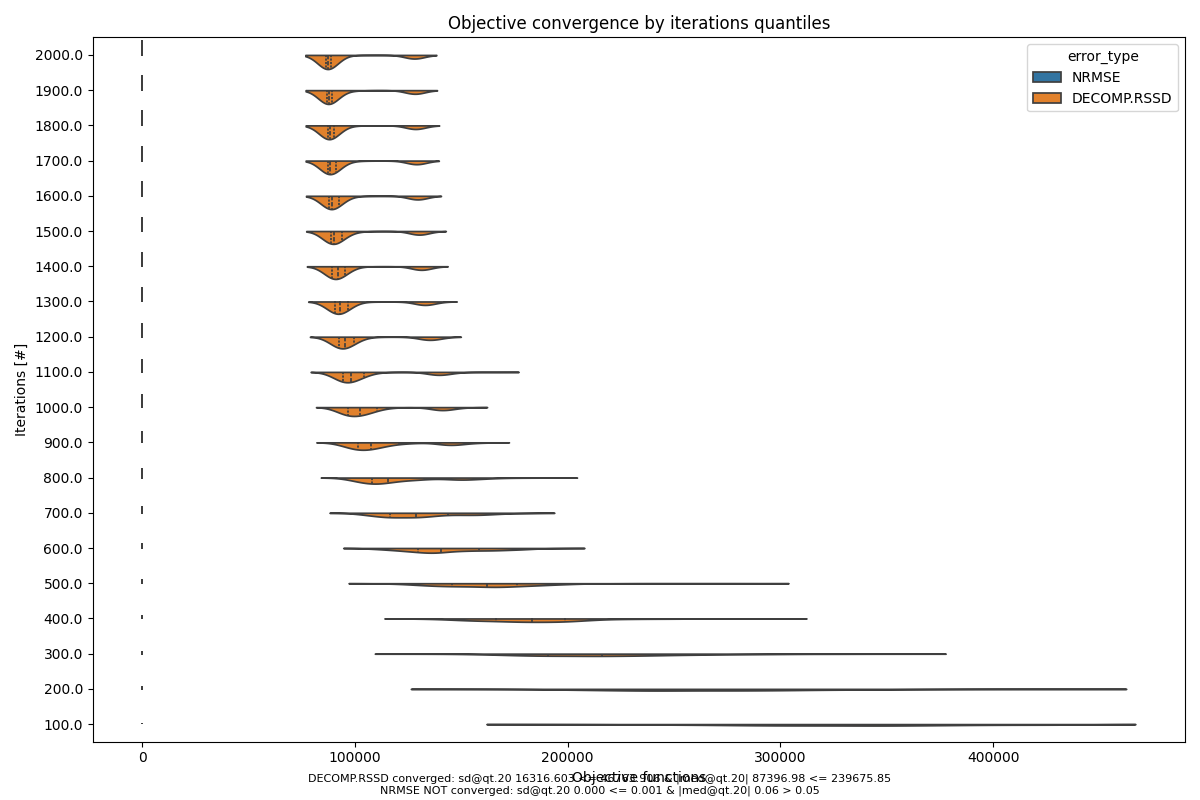

In [15]:
from IPython.display import Image, display
import base64
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# 1. Display the MOO Distribution Plot
if "moo_distrb_plot" in output_models.convergence:
    moo_distrb_plot = output_models.convergence["moo_distrb_plot"]
    display(Image(data=base64.b64decode(moo_distrb_plot)))

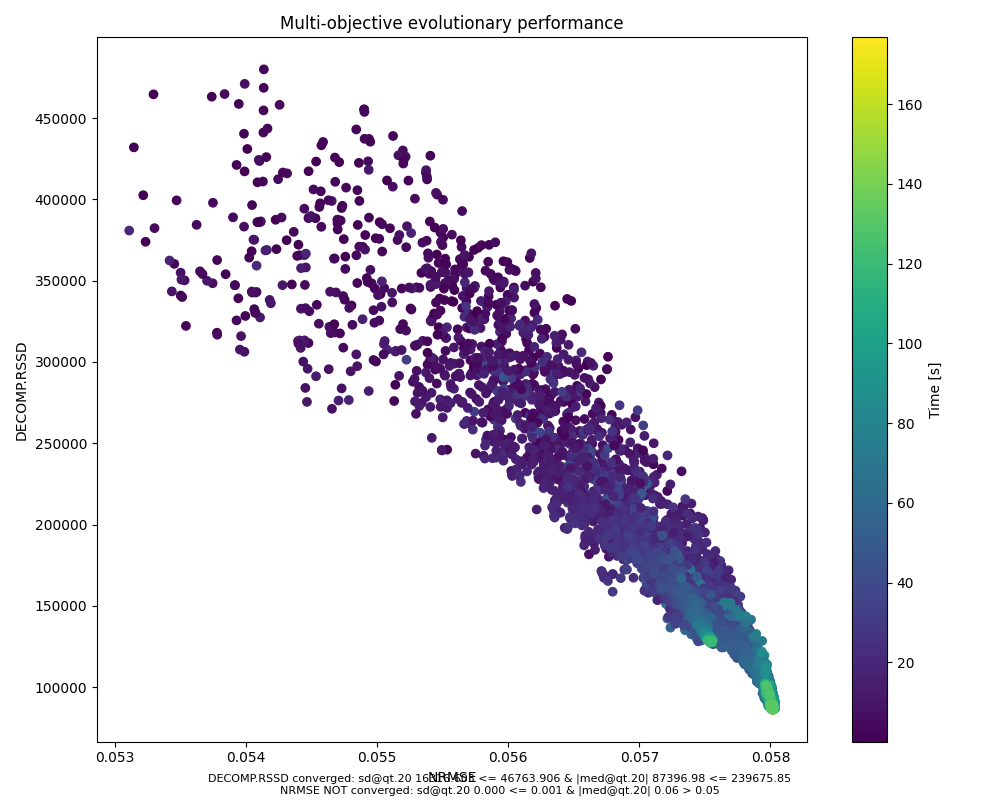

In [16]:
# 2. Display the MOO Cloud Plot
if "moo_cloud_plot" in output_models.convergence:
    moo_cloud_plot = output_models.convergence["moo_cloud_plot"]
    display(Image(data=base64.b64decode(moo_cloud_plot)))

In [17]:
# 3. Print convergence messages
if "conv_msg" in output_models.convergence:
    for msg in output_models.convergence["conv_msg"]:
        print(msg)

DECOMP.RSSD converged: sd@qt.20 16316.603 <= 46763.906 & |med@qt.20| 87396.98 <= 239675.85
NRMSE NOT converged: sd@qt.20 0.000 <= 0.001 & |med@qt.20| 0.06 > 0.05


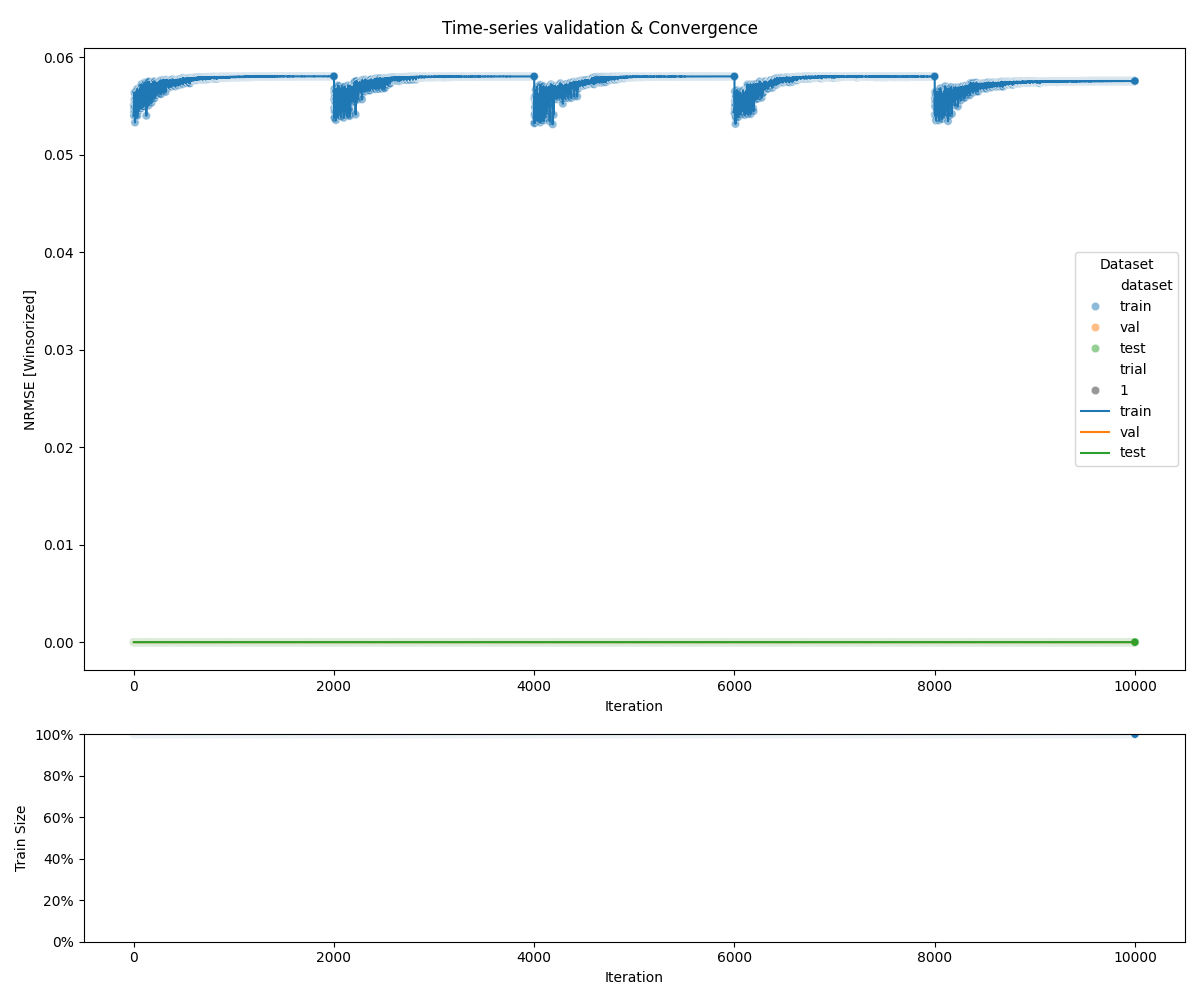

In [18]:
# 4. Display time series validation and convergence plots
if "ts_validation_plot" in output_models.convergence:
    ts_validation_plot = output_models.convergence["ts_validation_plot"]
    display(Image(data=base64.b64decode(ts_validation_plot)))

In [19]:
best_model_id = output_models.select_id
print(f"Best model ID: {best_model_id}")

Best model ID: 2_1962_1
